In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np

# Download Stock Data for Bayer from Yahoo Finance

In [2]:
bayer = yf.download(
        tickers = "BAYRY",
        period = 'max',
        interval = '1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
bayer

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-11-18,9.62500,9.68750,9.50000,9.62500,5.139757,98400
1996-11-19,9.75000,9.75000,9.53125,9.75000,5.206507,45200
1996-11-20,9.75000,9.81250,9.62500,9.75000,5.206507,32000
1996-11-21,9.78125,9.81250,9.65625,9.78125,5.223194,54400
1996-11-22,9.81250,9.84375,9.68750,9.81250,5.239882,32800
...,...,...,...,...,...,...
2021-10-14,13.91000,13.95000,13.87000,13.94000,13.940000,307200
2021-10-15,13.93000,14.00000,13.91000,13.98000,13.980000,409400
2021-10-18,13.63000,13.63000,13.56000,13.63000,13.630000,702700


In [4]:
delta = pd.Series(np.log(bayer[-300:]['Open'].values/bayer[-301:-1]['Open'].values))

In [5]:
delta.index=bayer.index[-300:]

<AxesSubplot:xlabel='Date'>

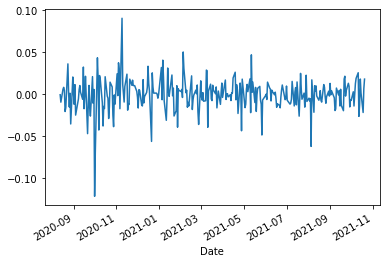

In [6]:
delta.plot()

# Basic Simulator

In [7]:
import numpy as np
import math
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
class stochasticprocess:
    '''Brownian Motion'''
    '''iterative generation of an asset's price over time; need to know where we are and where we're going'''
    
    def time_step(self):
        '''generate price based on where we are'''
        dW = np.random.normal(0, math.sqrt(self.delta_t)) #change in brownian motion
        dS = self.drift*self.delta_t*self.current_asset_price+self.volatility*self.current_asset_price*dW #use that motion to update asset price
        '''we drift per unit time; this could be reconstrued probabilistically instead'''
        
        self.asset_prices.append(self.current_asset_price + dS)
        self.current_asset_price = self.current_asset_price + dS
    
    def __init__(self, drift, volatility, delta_t, initial_asset_price):
        self.drift = drift #where we're going
        self.volatility = volatility #where we're going
        self.delta_t = delta_t #how far forward in time we're going
        self.current_asset_price = initial_asset_price # where we are
        self.asset_prices = [initial_asset_price]

In [9]:
p = stochasticprocess(.2, .3, 1/365, 300) # instantiate the model

In [10]:
p.time_step() # do one time step

In [11]:
p.asset_prices

[300, 305.2816902554538]

In [12]:
processes = []
for i in range(0, 100):
    processes.append(stochasticprocess(.2, .1, 1/365, 300)) 
    #use historical returns to derive drift, volatility, daily bars, current asset price
    

for process in processes:
    tte = 1 #year
    while(tte - process.delta_t >0): #delta_t in days
        process.time_step()
        tte = tte - process.delta_t

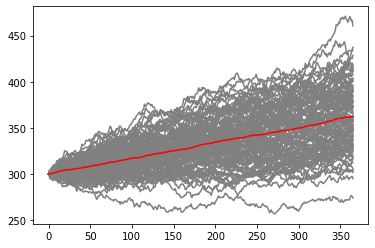

In [13]:
x=np.arange(0,len(processes[0].asset_prices))

for process in processes:
    plt.plot(x, process.asset_prices, color='grey')


average = np.zeros(len(processes[0].asset_prices))
for process in processes:
    average = np.array(process.asset_prices) + average

average = average/len(processes)    

plt.plot(x, average, color='red')
plt.show()

# Do it for Real

In [14]:
log_returns = pd.Series(np.log(bayer[-170:]['Adj Close'].values/bayer[-171:-1]['Adj Close'].values))

In [15]:
Bayer170day_historical_volatility = np.std(log_returns)*252
Bayer170day_historical_volatility

3.8683668824538398

In [16]:
Bayer170day_drift = np.mean(bayer[-170:]['Adj Close'].pct_change())*252

In [17]:
Bayer170_starting_price = bayer.iloc[-170]['Adj Close']
Bayer170_starting_price

15.698851585388184

In [18]:
multi_model=[]
for i in range(0,100):
    processes = []
    for i in range(0, 1000):
        processes.append(stochasticprocess(Bayer170day_drift, Bayer170day_historical_volatility, 1/365, Bayer170_starting_price)) 
        #use historical returns to derive drift, volatility, daily bars, current asset price


    for process in processes:
        tte = 1 #year
        while(tte - process.delta_t >0): #delta_t in days
            process.time_step()
            tte = tte - process.delta_t


    x=np.arange(0,len(processes[0].asset_prices))

    average = np.zeros(len(processes[0].asset_prices))
    for process in processes:
        average = np.array(process.asset_prices) + average

    average = average/len(processes)
    multi_model.append(average)

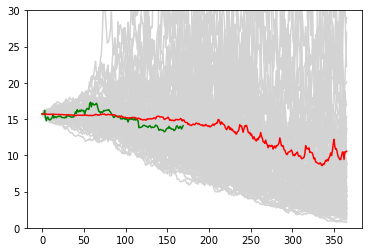

In [19]:
actual = list(bayer[-170:]['Adj Close'].values)
actual = actual + [np.nan for i in range(0,(366-170))]


multi_model_average = np.zeros(len(multi_model[0]))
for average in multi_model:
    plt.plot(x, average, color='lightgrey')
    multi_model_average = np.array(average) + multi_model_average

multi_model_average = multi_model_average/len(multi_model)
    
plt.plot(x, actual, color='green')
plt.plot(x, multi_model_average, color='red')
plt.ylim([0,30])
plt.show()